In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

url="https://raw.githubusercontent.com/e-Phi/Data-projects/refs/heads/main/quantvision_financial_dataset_200.csv"


In [2]:
df=pd.read_csv(url)
df.head()



,lookback_days,asset_type,market_regime,high_volatility,trend_continuation,technical_score,edge_density,slope_strength,candlestick_variance,pattern_symmetry,future_trend
0,48,equity,bullish,0,1,59.99,0.504,0.298,1.572,0.768,1
1,38,index,bullish,1,1,78.54,0.559,0.037,0.692,0.538,1
2,24,equity,bullish,1,0,56.03,0.617,0.212,1.419,0.301,1
3,52,equity,bullish,0,0,66.51,0.360,0.347,0.699,0.498,1
4,17,equity,bullish,1,1,61.21,0.492,0.144,2.520,0.828,1


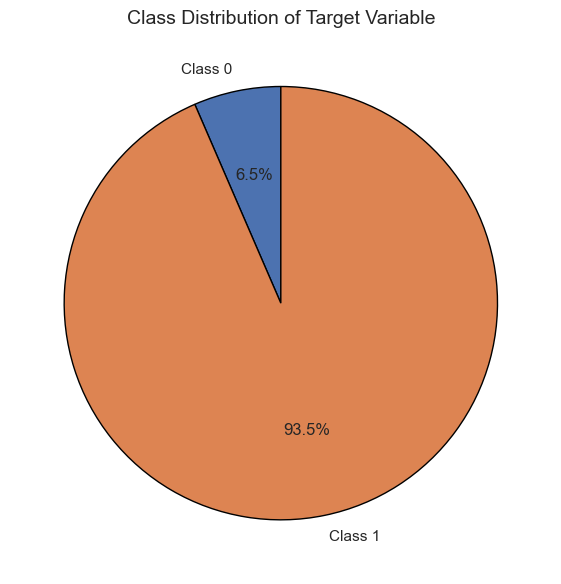

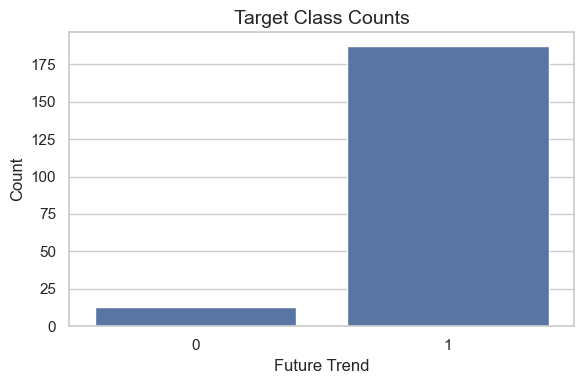

In [3]:

import seaborn as sns

sns.set(style="whitegrid")

class_counts = df["future_trend"].value_counts().sort_index()

plt.figure(figsize=(6, 6))
plt.pie(
    class_counts.values,
    labels=[f"Class {i}" for i in class_counts.index],
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops={"edgecolor": "black"}
)
plt.title("Class Distribution of Target Variable", fontsize=14)
plt.tight_layout()
plt.show()
plt.figure(figsize=(6, 4))
sns.countplot(
    x="future_trend",
    data=df
)
plt.title("Target Class Counts", fontsize=14)
plt.xlabel("Future Trend")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



In [4]:
counts = df["future_trend"].value_counts().sort_index()
proportions = df["future_trend"].value_counts(normalize=True).sort_index()
imbalance_ratio = counts.max() / counts.min()

print("Class counts:\n", counts)
print("Class proportions:\n", proportions)
print("Imbalance ratio:", imbalance_ratio)

Class counts:
 future_trend
0     13
1    187
Name: count, dtype: int64
Class proportions:
 future_trend
0    0.065
1    0.935
Name: proportion, dtype: float64
Imbalance ratio: 14.384615384615385


In [5]:
y = df["future_trend"]
X = df.drop(columns=["future_trend"])
X_encoded = pd.get_dummies(
    X,
    columns=["market_regime", "asset_type"],
    drop_first=False 
)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.20,
    stratify=y,
    random_state=42
)




In [6]:
continuous_cols = [
    "lookback_days",
    "technical_score",
    "edge_density",
    "slope_strength",
    "candlestick_variance",
    "pattern_symmetry"
]
scaler = StandardScaler()

X_train[continuous_cols] = scaler.fit_transform(
    X_train[continuous_cols]
)

X_test[continuous_cols] = scaler.transform(
    X_test[continuous_cols]
)
train_dataset = X_train.copy()
train_dataset["future_trend"] = y_train.values

test_dataset = X_test.copy()
test_dataset["future_trend"] = y_test.values
print(train_dataset.head())


     lookback_days  high_volatility  trend_continuation  technical_score  \
31        1.132469                1                   0        -0.738531   
111      -1.159433                1                   1        -0.268390   
148      -1.092024                1                   1         0.514276   
108      -0.957206                1                   1         0.351925   
109       1.739149                0                   1         1.668995   

     edge_density  slope_strength  candlestick_variance  pattern_symmetry  \
31       0.366192       -2.371427             -0.169912         -2.317923   
111      1.419954        1.283782              1.693257         -0.500166   
148      2.111484        0.247470              1.372197          0.570102   
108      1.666929       -0.695655              0.683969          1.538439   
109      0.514377        1.245221              1.271439         -0.143410   

     market_regime_bearish  market_regime_bullish  market_regime_sideways  \
31 

In [7]:
w0 = 4.0
model = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    class_weight={0: w0, 1: 1.0}
)
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_test)[:, 1]
threshold = 0.49
y_pred = (y_prob >= threshold).astype(int)


print("Accuracy  :", accuracy_score(y_test, y_pred))
print("Precision :", precision_score(y_test, y_pred))
print("Recall    :", recall_score(y_test, y_pred))
print("F1 score  :", f1_score(y_test, y_pred))
print("ROC AUC   :", roc_auc_score(y_test, y_prob))

print(confusion_matrix(y_test, y_pred))

print(classification_report(
    y_test,
    y_pred,
    labels=[0, 1],
    target_names=["class_0", "class_1"],
    digits=4
))


Accuracy  : 0.95
Precision : 1.0
Recall    : 0.9459459459459459
F1 score  : 0.9722222222222222
ROC AUC   : 0.963963963963964
[[ 3  0]
 [ 2 35]]
              precision    recall  f1-score   support

     class_0     0.6000    1.0000    0.7500         3
     class_1     1.0000    0.9459    0.9722        37

    accuracy                         0.9500        40
   macro avg     0.8000    0.9730    0.8611        40
weighted avg     0.9700    0.9500    0.9556        40



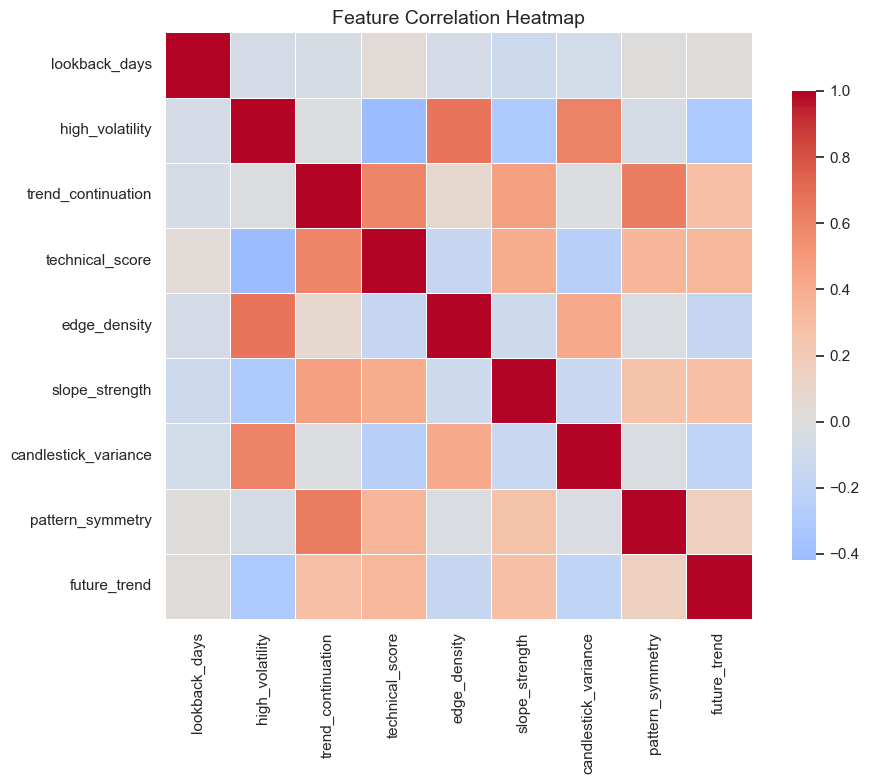

In [8]:

numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()


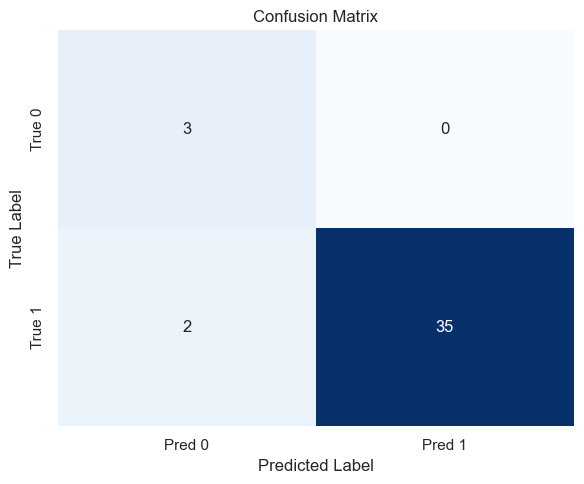

In [9]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

model_nn = Sequential([
    Dense(16, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(8, activation="relu"),
    Dense(1, activation="sigmoid")
])

model_nn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy"
)

class_weights = {
    0: 2.1,
    1: 1.0
}

model_nn.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=7,
    class_weight=class_weights,
    verbose=0
)


c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
y_prob_nn = model_nn.predict(X_test).ravel()

threshold = 0.7
y_pred_nn = (y_prob_nn >= threshold).astype(int)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [12]:
print("Accuracy  :", accuracy_score(y_test, y_pred_nn))
print("Precision :", precision_score(y_test, y_pred_nn))
print("Recall    :", recall_score(y_test, y_pred_nn))
print("F1 score  :", f1_score(y_test, y_pred_nn))
print("ROC AUC   :", roc_auc_score(y_test, y_prob_nn))

print(confusion_matrix(y_test, y_pred_nn))

print(classification_report(
    y_test,
    y_pred_nn,
    labels=[0, 1],
    target_names=["class_0", "class_1"],
    digits=4
))


Accuracy  : 0.975
Precision : 1.0
Recall    : 0.972972972972973
F1 score  : 0.9863013698630136
ROC AUC   : 0.972972972972973
[[ 3  0]
 [ 1 36]]
              precision    recall  f1-score   support

     class_0     0.7500    1.0000    0.8571         3
     class_1     1.0000    0.9730    0.9863        37

    accuracy                         0.9750        40
   macro avg     0.8750    0.9865    0.9217        40
weighted avg     0.9812    0.9750    0.9766        40

